In [322]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt

import joblib
import pickle

import optuna

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, RocCurveDisplay, roc_auc_score, roc_curve

In [323]:
import sys

sys.path.append('../utils')

In [324]:
from predict import predict_class

In [325]:
TOKENIZER_PATH = '../learned_models'

X_TRAIN_PATH = '../data/x_train.json'
Y_TRAIN_PATH = '../data/y_train.json'

X_TEST_PATH = '../data/x_test.json'
Y_TEST_PATH = '../data/y_test.json'

In [326]:
with open(f'{TOKENIZER_PATH}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [327]:
x_train = pd.read_json(X_TRAIN_PATH).values
y_train = pd.read_json(Y_TRAIN_PATH)

x_test = pd.read_json(X_TEST_PATH).values
y_test = pd.read_json(Y_TEST_PATH)

In [328]:
MODELS = ['rfc', 'catboost', 'logistic_regression'] # Список доступных моделей

USED_MODEL = 'rfc'                                  # Выбранная модель

IS_RUN_OPTUNA = False                               # Запускать Optuna

NUM_WORDS = 5_000                                   # Максимальное количество слов
MAX_NEWS_LEN = 100                                  # Максимальная длина новости
NB_CLASSES = y_train.keys().shape[0]                # Количество классов

In [329]:
y_train_initial = y_train

y_train = y_train.values.argmax(axis=1)
y_test = y_test.values.argmax(axis=1)

In [330]:
def objective(trial):
    match USED_MODEL:
        case 'rfc':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 2, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
            }

            model = RandomForestClassifier(**params, random_state=42)
        case 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 400, step=100),
                'depth': trial.suggest_int('depth', 4, 7),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
                'border_count': trial.suggest_int('border_count', 32, 130),
                'verbose': False,
                'loss_function':'MultiClass'
            }

            model = CatBoostClassifier(**params, random_seed=42)
        case 'logistic_regression':
            params = {
                'multi_class': 'multinomial',
                'solver':'lbfgs',
                'penalty': trial.suggest_categorical('penalty', ['l2']),
                'C': trial.suggest_loguniform('C', 0.01, 10.0)
            }

            model = LogisticRegression(**params, random_state=42)
        case _:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 2, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
            }

            model = RandomForestClassifier(**params, random_state=42)
    
    # if USED_MODEL in ['catboost', 'logistic_regression']:
    #     model.fit(x_train, y_train.values.argmax(axis=1))
    # else:       
    #     model.fit(x_train, y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

In [331]:
if IS_RUN_OPTUNA:
    study = optuna.create_study(direction='maximize')
    
    study.optimize(objective, n_trials=50)

In [332]:
if IS_RUN_OPTUNA:
    best_params = study.best_params
     
    print(best_params)

In [333]:
match USED_MODEL:
    case 'rfc':
        # best_params = {
        #  'n_estimators': 200,
        #  'max_depth': 23,
        #  'min_samples_split': 19,
        #  'min_samples_leaf': 6
        # }

        best_params = {
            'n_estimators': 500, 
            'max_depth': 15, 
            'min_samples_leaf': 22,
            'min_samples_split': 27,
            'criterion': 'gini'
        }           
        
        model = RandomForestClassifier(**best_params, random_state=42, verbose=2)
    case 'catboost':
        model = CatBoostClassifier(**best_params, random_seed=42)
    case 'logistic_regression':
        best_params = {'penalty': 'l2', 'C': 0.10704555665735006}
        
        model = LogisticRegression(**best_params, random_state=42)
    case _:
        best_params = {
            'n_estimators': 500, 
            'max_depth': 15, 
            'min_samples_leaf': 22,
            'min_samples_split': 27,
            'criterion': 'gini'
        }
        
        USED_MODEL = 'rfc'
        
        model = RandomForestClassifier(**best_params, random_state=42, verbose=2)

In [334]:
# if USED_MODEL in ['catboost', 'logistic_regression']:
#     model.fit(x_train, y_train.values.argmax(axis=1))
# else:           
#     model.fit(x_train, y_train)
    
model.fit(x_train, y_train)    

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s


building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.8s


building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500


RandomForestClassifier(max_depth=15, min_samples_leaf=22, min_samples_split=27,
                       n_estimators=500, random_state=42, verbose=2)

In [335]:
y_pred_train = model.predict(x_train)

train_acc = accuracy_score(y_train, y_pred_train)

train_acc

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.1s


0.9276315789473685

In [336]:
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1064
           1       0.90      0.92      0.91      1064
           2       0.91      0.91      0.91      1064

    accuracy                           0.93      3192
   macro avg       0.93      0.93      0.93      3192
weighted avg       0.93      0.93      0.93      3192



In [337]:
y_pred_test = model.predict(x_test)

train_acc = accuracy_score(y_test, y_pred_test)

train_acc

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


0.7977346278317152

In [338]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       287
           1       0.65      0.59      0.62       158
           2       0.65      0.73      0.69       173

    accuracy                           0.80       618
   macro avg       0.76      0.76      0.76       618
weighted avg       0.80      0.80      0.80       618



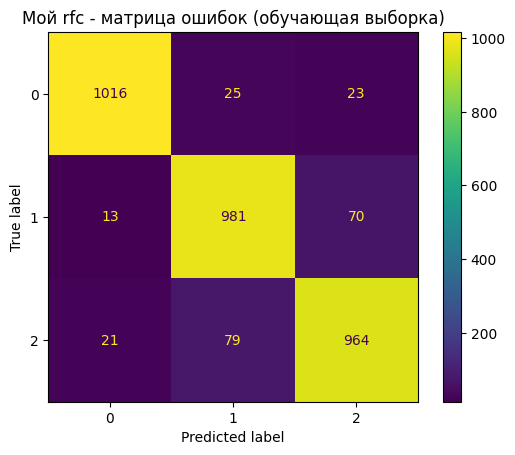

In [339]:
conf_matrix = confusion_matrix(y_train, y_pred_train)
conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_plot.plot()

plt.title(f'Мой {USED_MODEL} - матрица ошибок (обучающая выборка)')
plt.show()

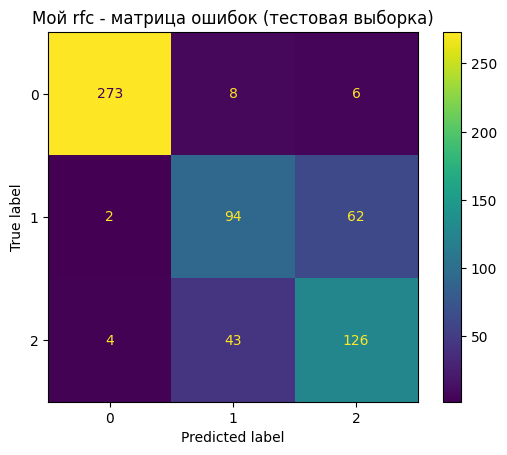

In [340]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_plot.plot()

plt.title(f'Мой {USED_MODEL} - матрица ошибок (тестовая выборка)')
plt.show()

In [341]:
text = 'В Ялте гаишникам пришлось гнаться за пьяным водителем и стрелять по колёсам, чтобы его остановить На патрулировании в ночи полицейские заметили авто с выключенными фарами. Водитель не остановился по требованию, началась погоня. После опасных заносов и виляний правоохранители приняли решение стрелять: один в воздух и семь — по колёсам. Только тогда тачка остановилась.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


'АВТО БАТЯ'

In [342]:
text = 'Ещё один радостный повод в первые дни лета 😎 Хаб Группы в Красноярске отметил 3 года! 🥳 ✈Сейчас из Международного аэропорта Красноярск им. Д.А. Хворостовского (https://t.me/kja_inform) мы выполняем полёты по 32 направлениям с учётом Москвы. 📍В летнем расписании еженедельно осуществляем до 42 рейсов в столицу, до 14 рейсов в Санкт-Петербург, Иркутск, Новосибирск, до 13 рейсов в Сочи, до 10 рейсов в Благовещенск. 🌍Широкая сеть маршрутов из сердца Сибири включает зарубежные пункты: Алматы, Бангкок, Бишкек, Пхукет, Харбин, Астана, Ош, Пекин, Санья, Ташкент.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


'АВТО БАТЯ'

In [343]:
text = 'Интегрировали станцию Кутузовская МЦД-4 с метро и МЦК  Первыми по новому крытому пешеходному мосту прошли мэр Москвы Сергей Собянин, глава РЖД Олег Белозёров и глава Сбербанка России Герман Греф. Переход сделали в едином стиле со станцией Кутузовская, чтобы он гармонично сочетался и с железнодорожной инфраструктурой, и с окружающей застройкой.'

predict_class(model, tokenizer, text, y_train_initial, MAX_NEWS_LEN)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


'АВТО БАТЯ'

In [344]:
SAVE_MODEL_PATH = '../learned_models'

joblib.dump(model, f'{SAVE_MODEL_PATH}/model_{USED_MODEL}.pickle')

['../learned_models/model_rfc.pickle']